# Machine Learning: A Quantitative Approach

In [2]:
%matplotlib inline

In [43]:
import sys, csv
import time

import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from time import time
import matplotlib.style as style
from collections import Counter
import seaborn as sns

from sklearn import linear_model
import sklearn.datasets
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import PolynomialFeatures

In [4]:
style.use('seaborn-poster') # sets the size of the charts
style.use('ggplot') # set the theme for matplotlib

In [5]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

### Common

In [25]:
def load_dataframe(data_source, features):
    df = pd.read_csv(data_source, low_memory=False)
    df_selected_features = df[features]
    df_selected_features_filtered = df_selected_features[df_selected_features.displ > 0]
    
    return df_selected_features_filtered

In [26]:
def reshape_data(my_data, features):
    X_sorted = my_data.sort_values(by=features)
    X_grouped_by_mean = pd.DataFrame({'mean' : \
                                     X_sorted.groupby(features[0])[features[1]].mean()}).reset_index()
    
    X_reshaped = X_grouped_by_mean[features[0]].values.reshape(-1, 1)
    y_reshaped = X_grouped_by_mean['mean'].values.reshape(-1, 1)
    
    return X_reshaped, y_reshaped

In [27]:
def split_data(my_data, test_size):
    test_set = my_data.sample(frac=test_size, replace=True)
    train_set = my_data.sample(frac=(1 - test_size), replace=True)
    
    return train_set, test_set

In [89]:
def score_and_plot (model, test_set_x, test_set_y, test_set_y_pred, i, type):
    '''For linear models only.'''
    
    print('Intercept & Coefficients: ', model.intercept_, model.coef_)
    mse = mean_squared_error(test_set_y, test_set_y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(test_set_y, test_set_y_pred)
    if (type == 0):
        cv_mse_scores.append (mse)
        cv_rmse_scores.append (rmse)
        cv_r2_scores.append (r2)
    else:
        test_mse_scores.append (mse)
        test_rmse_scores.append (rmse)
        test_r2_scores.append (r2)
    print("Mean squared error: %.2f " % mse, "Root mean squared error: %.2f" % rmse,  \
        'R-squared score: %.2f' % r2)

    # Plot outputs
    axarr [type, i].scatter(test_set_x, test_set_y,  s=12, color='red')
    axarr [type, i].plot(test_set_x, test_set_y_pred, color='blue', linewidth=2)

    if (type == 0 and i == 2):
        axarr [type, i].set_title ("CV runs: Fuel economy (MPG) versus Engine displacement (liters)") 
    if (type == 1 and i == 2):
        axarr [type, i].set_title ("Test runs: Fuel economy (MPG) versus Engine displacement (liters)")

In [90]:
def split_kfolds(df, k):
    k = k
    sub_df = []
    for i in range(k):
        sub_df.append(pd.DataFrame(columns=df.columns))
        
    for i in range(0, len(df), k):
        for j in range(k):
            x = i + j
            if(x < len(df)):
                sub_df[j] = sub_df[j].append(df.iloc[x], ignore_index=True)
    
    return sub_df

In [91]:
def make_train_validate_frames(frames, k, k_validate):
    validate_frame = frames[k_validate]
    train_frame = pd.DataFrame()
    for i in range(k -1):
        if(i != k_validate):
            train_frame = pd.concat([train_frame, frames[i]])
            
    return train_frame.reset_index(), validate_frame

In [92]:
def cross_validate(frames, k, features):
    test_frame = frames[k - 1]
    for i in range(k - 1):
        train_frame, validate_frame = make_train_validate_frames(frames, k, i)
        process(train_frame, validate_frame, features, i, 0)
        process(train_frame, test_frame, features, i, 1)

In [97]:
def process(train_set, test_set, features, i, type):
    train_set_x, train_set_y, = reshape_data(train_set, features)
    test_set_x, test_set_y = reshape_data(test_set, features)
    
    poly_features = PolynomialFeatures(degree = 2, include_bias = False)
    train_set_x_poly = poly_features.fit_transform(train_set_x)
    
    model = linear_model.LinearRegression()
    model.fit(train_set_x_poly, train_set_y)
    
    test_set_x_poly = poly_features.fit_transform(test_set_x)
    test_set_y_pred = model.predict(test_set_x_poly)
    
    score_and_plot(model, test_set_x, test_set_y, test_set_y_pred, i, type)

In [94]:
def print_scores():
    print ("CV Scores:") 
    np_mse = np.array(cv_mse_scores)
    np_rmse = np.array(cv_rmse_scores)
    np_r2 = np.array(cv_r2_scores)
    print ("\tCV MSE Scores: ", cv_mse_scores) 
    print ("\tCV RMSE Scores:", cv_rmse_scores) 
    print ("\tCV R2 Scores:", cv_r2_scores) 
    print ("\tCV MSE Scores (mean/std): ", np_mse.mean(), "/", np_mse.std()) 
    print ("\tCV RMSE Scores (mean/std):",  np_rmse.mean(), "/", np_rmse.std()) 
    print ("\tCV R2 Scores: (mean/std)",  np_r2.mean(), "/", np_r2.std()) 
    
    print ("Test Scores:") 
    np_mse = np.array(test_mse_scores)
    np_rmse = np.array(test_rmse_scores)
    np_r2 = np.array(test_r2_scores)
    print ("\tTest MSE Scores:",  test_mse_scores) 
    print ("\tTest RMSE Scores:",  test_rmse_scores) 
    print ("\tTest R2 Scores:",  test_r2_scores)
    print ("\tTest MSE Scores (mean/std): ", np_mse.mean(), "/", np_mse.std()) 
    print ("\tTest RMSE Scores (mean/std):",  np_rmse.mean(), "/", np_rmse.std()) 
    print ("\tTest R2 Scores: (mean/std)",  np_r2.mean(), "/", np_r2.std())  

### Cross-Validation

In [103]:
start = time()

data_source = "datasets/vehicles.csv"
features = ['displ', 'UHighway']
selector = "df_selected_features.displ > 0"

fuel_economy = load_dataframe(data_source, features)
train_set, test_set = split_data(fuel_economy, test_size=0.5)

train_set_x, train_set_y = reshape_data(train_set, features)
test_set_x, test_set_y = reshape_data(test_set, features)

In [104]:
cv_mse_scores = []
cv_rmse_scores = []
cv_r2_scores = []
    
test_mse_scores = []
test_rmse_scores = []
test_r2_scores = []

Intercept & Coefficients:  [59.11273645] [[-10.96224917   0.83569071]]
Mean squared error: 20.39  Root mean squared error: 4.52 R-squared score: 0.78
Intercept & Coefficients:  [59.11273645] [[-10.96224917   0.83569071]]
Mean squared error: 16.83  Root mean squared error: 4.10 R-squared score: 0.80
Intercept & Coefficients:  [59.73686038] [[-11.22793966   0.86097003]]
Mean squared error: 21.85  Root mean squared error: 4.67 R-squared score: 0.76
Intercept & Coefficients:  [59.73686038] [[-11.22793966   0.86097003]]
Mean squared error: 16.90  Root mean squared error: 4.11 R-squared score: 0.80
Intercept & Coefficients:  [59.12281295] [[-11.00189651   0.84326533]]
Mean squared error: 16.77  Root mean squared error: 4.09 R-squared score: 0.79
Intercept & Coefficients:  [59.12281295] [[-11.00189651   0.84326533]]
Mean squared error: 16.81  Root mean squared error: 4.10 R-squared score: 0.80
Intercept & Coefficients:  [59.75132137] [[-11.2697305    0.86718819]]
Mean squared error: 13.49  Ro

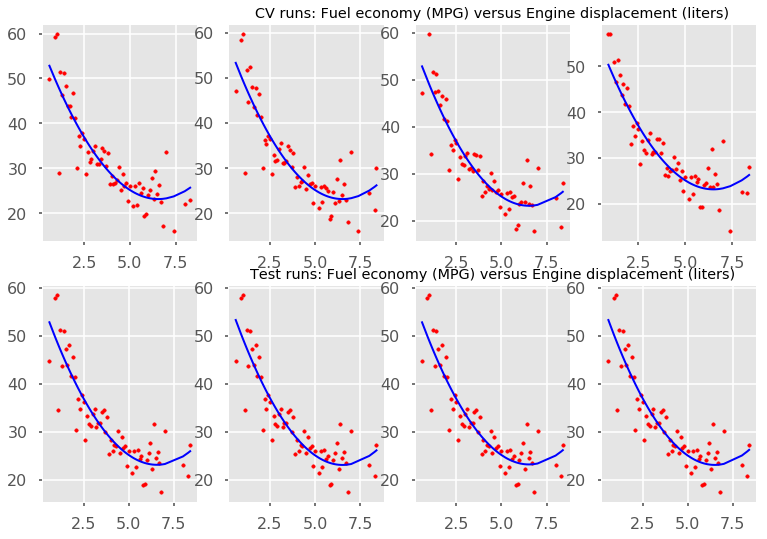

In [102]:
start = time()

k = 5
frames = split_kfolds (fuel_economy, k)
f, axarr = plt.subplots (2, 4)
cross_validate (frames, k, features)
print_scores()
print ("total time (seconds): ", (time() - start))
plt.show()